In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt


class Distance:
    """Calculate distances between two points."""
    
    def __init__(self, point_a, point_b):
        self.point_a = point_a
        self.point_b = point_b
    
    def get_distance(self):
        """Euclidean distance."""
        dx = self.point_a[0] - self.point_b[0]
        dy = self.point_a[1] - self.point_b[1]
        return math.sqrt(dx**2 + dy**2)
    
    def estimate_goto(self):
        return self.get_distance()
    
    def estimate_return(self):
        return self.get_distance()


class Speed:
    """Represents the vehicle speed."""
    
    def __init__(self, speed_kmh):
        self.speed = speed_kmh
    
    def estimate_goto(self):
        return self.speed
    
    def estimate_return(self):
        return self.speed


class PredictAvailable:
    """Predict number of available parking spaces."""
    
    def __init__(self, location_index, location, availability_list, current_time, empty_hours):
        self.index = location_index
        self.location = location
        self.availability_list = availability_list
        self.current_time = current_time
        self.empty_hours = empty_hours
    
    def estimate_available(self):
        hour_index = int(self.current_time + self.empty_hours)
        if hour_index < len(self.availability_list):
            return self.availability_list[hour_index]
        return 0


class ParkingSearch:
    """Search for feasible parking points given constraints."""
    
    def __init__(self, current_time, empty_hours, speed, parking_positions, parking_rates, parking_availability, start_point):
        self.current_time = current_time
        self.empty_hours = empty_hours
        self.speed = speed
        self.parking_positions = parking_positions
        self.parking_rates = parking_rates
        self.parking_availability = parking_availability
        self.start_point = start_point
        
        self.feasible_positions = []
        self.feasible_rates = []
        self.feasible_distances = []
    
    def check_feasible(self):
        max_drive_distance = self.empty_hours * self.speed
        for i, position in enumerate(self.parking_positions):
            distance = Distance(self.start_point, position)
            total_distance = distance.estimate_goto() + distance.estimate_return()
            
            available = PredictAvailable(i, position, self.parking_availability[i], self.current_time, self.empty_hours)
            if total_distance < max_drive_distance and available.estimate_available() > 0:
                self.feasible_positions.append(position)
                self.feasible_rates.append(self.parking_rates[i])
                self.feasible_distances.append(total_distance)
    
    def get_positions(self):
        return self.feasible_positions
    
    def get_rates(self):
        return self.feasible_rates
    
    def get_distances(self):
        return self.feasible_distances


class EstimateCost:
    """Estimate cost of parking vs driving."""
    
    def __init__(self, empty_hours, speed, start_point, parking_point, parking_fee, fuel_cost):
        self.empty_hours = empty_hours
        self.speed = speed
        self.start_point = start_point
        self.parking_point = parking_point
        self.parking_fee = parking_fee
        self.fuel_cost = fuel_cost
    
    def estimate_parking_cost(self):
        distance = Distance(self.start_point, self.parking_point)
        total_drive_distance = distance.estimate_goto() + distance.estimate_return()
        
        speed = Speed(self.speed)
        total_drive_time = total_drive_distance / speed.estimate_goto()  # hours
        
        parking_time = self.empty_hours - total_drive_time
        if parking_time > 0:
            total_cost = (distance.estimate_goto() * self.fuel_cost +
                          parking_time * self.parking_fee +
                          distance.estimate_return() * self.fuel_cost)
            return total_cost
        return float('inf')
    
    def estimate_drive_only_cost(self):
        return self.speed * self.empty_hours * self.fuel_cost

def generate_oclock_data(file_name, parking_ids):
    """Generate hourly availability DataFrame for parking lots."""
    df = pd.read_csv(file_name)
    
    # Convert 'time' column to fractional hours
    df['timex'] = df['time'].str[:2].astype(int) + df['time'].str[3:5].astype(int)/60
    
    df.set_index('id', inplace=True)
    hours = range(24)
    oclock_df = pd.DataFrame(0, index=hours, columns=parking_ids)
    
    for pid in parking_ids:
        if pid not in df.index:
            continue
        available = df.at[pid, 'availablecar']
        timex = df.at[pid, 'timex']
        
        if isinstance(available, str):
            available = [int(x) for x in available]
        if isinstance(timex, (float, int)):
            timex = [timex]
        
        for t, avail in zip(timex, available):
            if avail > 0:
                idx = [h for h in hours if -0.1 < t - h < 0.5]
                for h in idx:
                    oclock_df.at[h, pid] = avail
    
    return pd.DataFrame([{'id': pid, 'oclock': list(oclock_df[pid])} for pid in parking_ids])

In [3]:
file_target = 'parking_csv/TCmSV_06-03.csv'  #替代用即時數據
file_data = 'parking_csv/parking_data.csv'   #停車場基本資料
list_parkingid = [1, 2, 3, 41, 48, 88, 107, 177, 405, 472]

In [4]:
oclock_df = generate_oclock_data(file_target, list_parkingid)

parking_meta = pd.read_csv(file_data, index_col=0)
parking_meta = parking_meta[['id', 'name', 'wgs84x', 'wgs84y', 'payex_major']].copy()
parking_meta['id'] = pd.to_numeric(parking_meta['id'], errors='coerce').astype('Int64')

parking_data = pd.merge(parking_meta, oclock_df, on='id', how='inner')
parking_data

,id,name,wgs84x,wgs84y,payex_major,oclock
0,1,府前廣場地下停車場,121.562997,25.036089,30.0,"[0, 0, 0, 0, 0, 0, 0, 0, 660, 252, 97, 65, 82,..."
1,2,松壽廣場地下停車場,121.566280,25.037147,30.0,"[0, 0, 0, 0, 0, 0, 0, 0, 341, 202, 131, 97, 49..."
2,3,臺北市災害應變中心地下停車場,121.566226,25.028806,30.0,"[0, 0, 0, 0, 0, 0, 0, 0, 21, 12, 8, 3, 10, 0, ..."
3,41,忠信地下停車場,121.567783,25.040419,40.0,"[0, 0, 0, 0, 0, 0, 0, 0, 123, 95, 70, 53, 41, ..."
4,48,信義廣場地下停車場,121.565812,25.033146,40.0,"[0, 0, 0, 0, 0, 0, 0, 0, 301, 240, 192, 174, 1..."
5,88,三張里地下停車場,121.566749,25.030915,30.0,"[0, 0, 0, 0, 0, 0, 0, 0, 46, 25, 4, 5, 10, 10,..."
6,107,信義國小地下停車場,121.563227,25.031370,40.0,"[0, 0, 0, 0, 0, 0, 0, 0, 80, 58, 41, 35, 37, 3..."
7,177,BELLAVITA寶麗廣場停車場,121.567917,25.039730,120.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 143, 117, 81..."
8,405,遠東百貨信義分公司停車場,121.568392,25.036880,20.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 244, 193, 14..."
9,472,市府轉運站停車場,121.565164,25.040668,50.0,"[0, 0, 0, 0, 0, 0, 0, 0, 397, 365, 300, 266, 1..."


In [5]:
## params
currenttime = 9 #O'clock
emptyhours = 2 #hr
speed = 30 #km/hr
point_start = (12156.5, 2503.5)
fuelcost = 1.8 #NTD/km

parking_rates = parking_data['payex_major'].tolist()
parking_availability = parking_data['oclock'].tolist()
parking_positions = list(
    zip(
        100 * parking_data['wgs84x'],
        100 * parking_data['wgs84y']
    )
)

In [6]:
##尋找可行方案（匯入停車場資訊）
searchpoint = ParkingSearch(currenttime, emptyhours, speed, parking_positions, parking_rates, parking_availability,  point_start)
searchpoint.check_feasible()

In [7]:
feasible_positions = searchpoint.get_positions()
feasible_rates = searchpoint.get_rates()
parking_ids = parking_data['id'].tolist()

parking_costs = [
    {
        "id": parking_ids[i],
        "location": feasible_positions[i],
        "rate": feasible_rates[i],
        "cost": EstimateCost(
            emptyhours,
            speed,
            point_start,
            feasible_positions[i],
            feasible_rates[i],
            fuelcost
        ).estimate_parking_cost()
    }
    for i in range(len(feasible_positions))
]

drive_only_cost = {
    "id": -1,
    "location": (float('inf'), float('inf')),
    "rate": 0,
    "cost": EstimateCost(
        emptyhours,
        speed,
        point_start,
        point_start,
        float('inf'),
        fuelcost
    ).estimate_drive_only_cost()
}

df_costs = pd.DataFrame(parking_costs + [drive_only_cost])
df_costs

,id,location,rate,cost
0,1,"(12156.299732925112, 2503.608871399772)",30.0,60.364715
1,2,"(12156.628035534452, 2503.7146696000364)",30.0,60.399924
2,3,"(12156.62260284535, 2502.8806331929663)",30.0,61.010216
3,41,"(12156.778319103674, 2504.0419316888965)",40.0,80.568607
4,48,"(12156.581163492996, 2503.3146073617418)",40.0,80.188889
5,88,"(12156.67488676518, 2503.0915461015984)",30.0,60.710911
6,107,"(12156.322742598948, 2503.137022943796)",40.0,80.377016
7,177,"(12156.791712976386, 2503.9730235834463)",120.0,237.554741
8,405,"(12156.83919399643, 2503.687998053841)",20.0,40.879034
9,472,"(12156.5163622336, 2504.066791522695)",50.0,100.151207


In [8]:
df_costs[df_costs['cost'] == min(df_costs['cost'])]

,id,location,rate,cost
8,405,"(12156.83919399643, 2503.687998053841)",20.0,40.879034


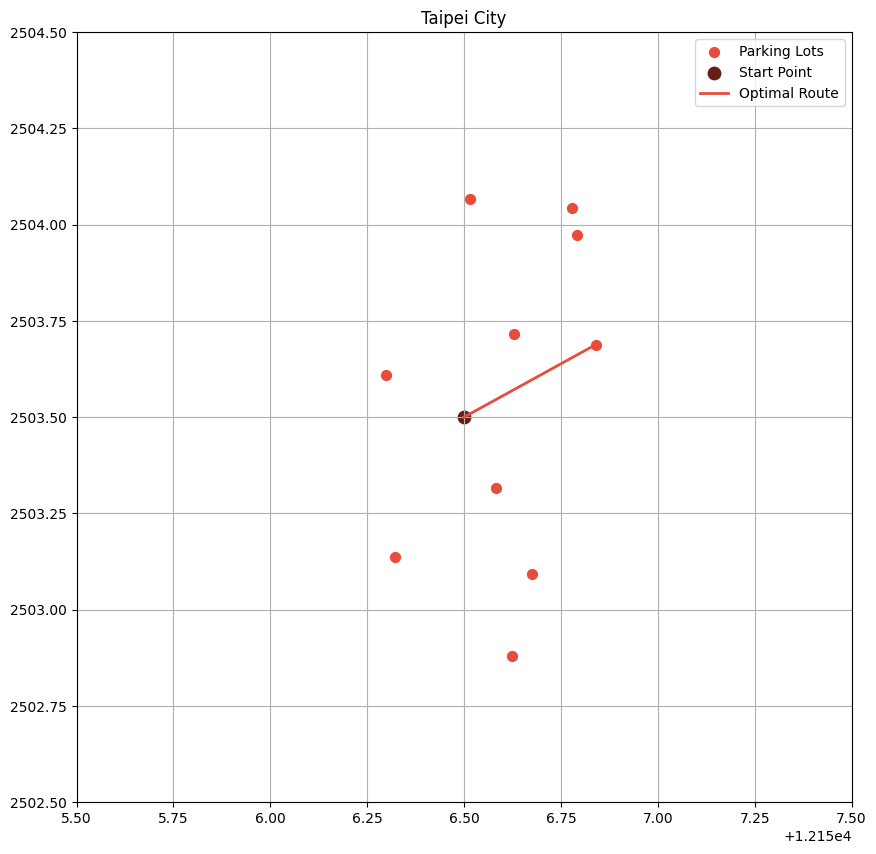

In [9]:
locations = df_costs['location'].tolist()
loc_x = [loc[0] for loc in locations[:-1]]
loc_y = [loc[1] for loc in locations[:-1]]

start_x, start_y = point_start

min_cost_location = df_costs.loc[df_costs['cost'].idxmin(), 'location']
route_x = [start_x, min_cost_location[0]]
route_y = [start_y, min_cost_location[1]]

plt.figure(figsize=(10, 10))
plt.title('Taipei City')
plt.xlim(12155.5, 12157.5)
plt.ylim(2502.5, 2504.5)
plt.grid(True)
plt.scatter(loc_x, loc_y, color='#E74C3C', label='Parking Lots', s=50)
plt.scatter(start_x, start_y, color='#641E16', label='Start Point', s=80)
plt.plot(route_x, route_y, color='#E74C3C', linewidth=2, label='Optimal Route')
plt.legend()
plt.show()